# 6. Performance Evaluation for Model Tuning

In [1]:
import os
import time

from functions.tuning import Tuner
from functions.plotting import Plotter

%matplotlib inline

In [2]:
# Set hyperparameters
BATCH_SIZES = [32, 64, 128] # samples per batch to load
H_LAYERS = [[256, 256], [512, 256], [512, 512], [1024, 516]]
SPLIT_SIZE = 0.15 # validation & test dataset size
N_PREDS = 5 # number of model predictions (e.g. top-5 error rate)
N_CLASSES = 35 # number of classes
MAIN_FILEPATH = 'dataset/resized'
SAVE_FOLDER = 'saved_models'
MODEL_NAMES = ["GoogLeNet", "MobileNet-V2", "ResNet-34"]
SEED = 1

## 6.1 Data Preparation

In [3]:
# Set tune class object
tune = Tuner()

CUDA is available. Device has been set to GPU.


In [4]:
# Transform the dataset
dataset = tune.set_data(MAIN_FILEPATH)

In [5]:
# Set plot class object
vis = Plotter(tune.labels)

CUDA is available. Device has been set to GPU.


## 6.2 Visualise Results

In [6]:
model_stats = []
count = 1

start_time = time.time()
for i in range(len(BATCH_SIZES)):
    # Split data
    _, _, test_loader = tune.utils.split_data(dataset, BATCH_SIZES[i], SPLIT_SIZE, SEED)
    
    for h in range(len(H_LAYERS)):
        # Retrieve model filepaths and set initial models
        model_paths = os.listdir(SAVE_FOLDER)
        cnn_models = tune.set_initial_models(N_CLASSES, H_LAYERS[h])
        N_MODELS = (len(BATCH_SIZES) * len(H_LAYERS)) * len(cnn_models)
        
        # Calculate predictions, test labels, and probabilities
        for m in range(len(cnn_models)):
            model, name = tune.set_model(model_paths, cnn_models[m], MODEL_NAMES[m])
            print(f"Calculating preds and stats for {name}...", end=" ")
            y_pred, y_true, n_preds = tune.utils.predict(model, test_loader, N_PREDS, 
                                                         store_labels=True)
            
            # Calculate statistics
            model_stats.append(tune.utils.calc_statistics(name, y_pred, y_true, n_preds))
            print(f"Complete ({count}/{N_MODELS}).")
            count += 1
tune.utils.time_taken(time.time() - start_time)
print("Plotting statistics...", end=" ")
all_stats = vis.plot_stats(model_stats)
print("Complete.")

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to C:\Users\Frazzle/.cache\torch\hub\checkpoints\googlenet-1378be20.pth
100.0%
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\Frazzle/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100.0%
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\Frazzle/.cache\torch\hub\checkpoints\resnet34-333f7ec4.pth
78.5%

Calculating preds and stats for GoogLeNet_32_256_256... Complete (1/36).
Calculating preds and stats for MobileNet-V2_32_256_256... Complete (2/36).
Calculating preds and stats for ResNet-34_32_256_256... Complete (3/36).
Calculating preds and stats for GoogLeNet_32_512_256... Complete (4/36).
Calculating preds and stats for MobileNet-V2_32_512_256... Complete (5/36).
Calculating preds and stats for ResNet-34_32_512_256... Complete (6/36).
Calculating preds and stats for GoogLeNet_32_512_512... Complete (7/36).
Calculating preds and stats for MobileNet-V2_32_512_512... Complete (8/36).
Calculating preds and stats for ResNet-34_32_512_512... Complete (9/36).
Calculating preds and stats for GoogLeNet_32_1024_516... Complete (10/36).
Calculating preds and stats for MobileNet-V2_32_1024_516... Complete (11/36).
Calculating preds and stats for ResNet-34_32_1024_516... Complete (12/36).
Calculating preds and stats for GoogLeNet_64_256_256... Complete (13/36).
Calculating preds and stats for 

In [7]:
all_stats[all_stats['Name'].str.contains(MODEL_NAMES[0])].style.hide_index()

Name,Accuracy,Top-1 Error,Top-5 Error,Precision,Recall,F1-Score
GoogLeNet_32_256_256,0.674738,0.325262,0.082728,0.535714,0.542169,0.538922
GoogLeNet_32_512_256,0.688862,0.311138,0.077482,0.573333,0.754386,0.651515
GoogLeNet_32_512_512,0.680791,0.319209,0.079096,0.661290,0.482353,0.557823
GoogLeNet_32_1024_516,0.710654,0.289346,0.071832,0.775510,0.463415,0.580153
GoogLeNet_64_256_256,0.705811,0.294189,0.074657,0.589744,0.647887,0.617450
GoogLeNet_64_512_256,0.714286,0.285714,0.071832,0.800000,0.416667,0.547945
GoogLeNet_64_512_512,0.712268,0.287732,0.061743,0.724138,0.437500,0.545455
GoogLeNet_64_1024_516,0.720339,0.279661,0.062550,0.707692,0.741935,0.724409
GoogLeNet_128_256_256,0.715900,0.284100,0.061340,0.789474,0.489130,0.604027
GoogLeNet_128_512_256,0.742938,0.257062,0.060533,0.721311,0.733333,0.727273


In [8]:
all_stats[all_stats['Name'].str.contains(MODEL_NAMES[1])].style.hide_index()

Name,Accuracy,Top-1 Error,Top-5 Error,Precision,Recall,F1-Score
MobileNet-V2_32_256_256,0.763115,0.236885,0.049637,0.714286,0.762712,0.737705
MobileNet-V2_32_512_256,0.781275,0.218725,0.047215,0.758065,0.534091,0.626667
MobileNet-V2_32_512_512,0.774415,0.225585,0.046408,0.571429,0.482759,0.523364
MobileNet-V2_32_1024_516,0.755851,0.244149,0.044794,0.647887,0.657143,0.652482
MobileNet-V2_64_256_256,0.794189,0.205811,0.041566,0.781818,0.518072,0.623188
MobileNet-V2_64_512_256,0.801049,0.198951,0.037934,0.526786,0.737500,0.614583
MobileNet-V2_64_512_512,0.813559,0.186441,0.036723,0.647727,0.670588,0.658960
MobileNet-V2_64_1024_516,0.807506,0.192494,0.034302,0.793651,0.568182,0.662252
MobileNet-V2_128_256_256,0.804278,0.195722,0.041162,0.617978,0.820896,0.705128
MobileNet-V2_128_512_256,0.828491,0.171509,0.030266,0.736842,0.736842,0.736842


In [9]:
all_stats[all_stats['Name'].str.contains(MODEL_NAMES[-1])].style.hide_index()

Name,Accuracy,Top-1 Error,Top-5 Error,Precision,Recall,F1-Score
ResNet-34_32_256_256,0.752220,0.247780,0.054883,0.767857,0.605634,0.677165
ResNet-34_32_512_256,0.742938,0.257062,0.050444,0.733333,0.721311,0.727273
ResNet-34_32_512_512,0.757062,0.242938,0.043584,0.720588,0.662162,0.690141
ResNet-34_32_1024_516,0.741324,0.258676,0.052462,0.730159,0.516854,0.605263
ResNet-34_64_256_256,0.763115,0.236885,0.046005,0.670732,0.572917,0.617978
ResNet-34_64_512_256,0.788136,0.211864,0.039144,0.779412,0.716216,0.746479
ResNet-34_64_512_512,0.762712,0.237288,0.049637,0.683544,0.490909,0.571429
ResNet-34_64_1024_516,0.780065,0.219935,0.040355,0.757576,0.617284,0.680272
ResNet-34_128_256_256,0.766344,0.233656,0.041969,0.750000,0.600000,0.666667
ResNet-34_128_512_256,0.793785,0.206215,0.037530,0.717949,0.651163,0.682927


In [10]:
# Retrieve best models stats
best_models = []
for name in MODEL_NAMES:
    models_split = all_stats[all_stats['Name'].str.contains(name)]
    
    # Get best model
    idx = models_split['Accuracy'].idxmax()
    best_model = all_stats.iloc[idx, :]
    best_models.append(best_model) # Store in list

# Plot stats
best_model_stats = vis.plot_stats(best_models)
best_model_stats.style.hide_index()

Name,Accuracy,Top-1 Error,Top-5 Error,Precision,Recall,F1-Score
GoogLeNet_128_512_256,0.742938,0.257062,0.060533,0.721311,0.733333,0.727273
MobileNet-V2_128_512_256,0.828491,0.171509,0.030266,0.736842,0.736842,0.736842
ResNet-34_128_1024_516,0.803471,0.196529,0.033898,0.823529,0.861538,0.842105


In [11]:
# Store best models based on model stats
best_models = tune.save_best_models(best_model_stats, MODEL_NAMES, N_PREDS)

Calculating preds and stats for GoogLeNet... Complete (1/3).
Saving model... Complete.
Calculating preds and stats for MobileNet-V2... Complete (2/3).
Saving model... Complete.
Calculating preds and stats for ResNet-34... Complete (3/3).
Saving model... Complete.
Total time taken: 0.00 hrs 1.00 mins 21.12 secs


In [12]:
# Load best models
MODEL_FILENAMES = ['best_googlenet', 'best_mobilenetv2', 'best_resnet34']
best_model_layers = [[512, 256], [512, 256], [1024, 516]]
best_models = tune.set_initial_models(N_CLASSES, h_layers=best_model_layers)
tune.load_best_models(best_models, MODEL_FILENAMES)

Models loaded. Utility variables available:
	train_losses, valid_losses, batch_size, h_layers, stats,

	y_pred, y_true, n_preds, y_probas.


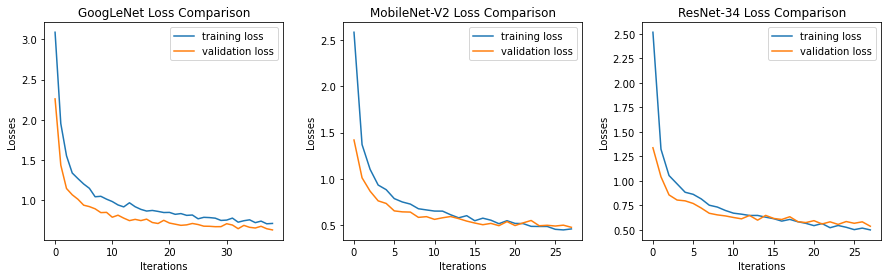

In [13]:
# Plot loss comparsion
vis.create_plots(best_models, MODEL_NAMES, figsize=(15, 4), plot_func=vis.plot_losses,
                 plot_name="best_model_losses")

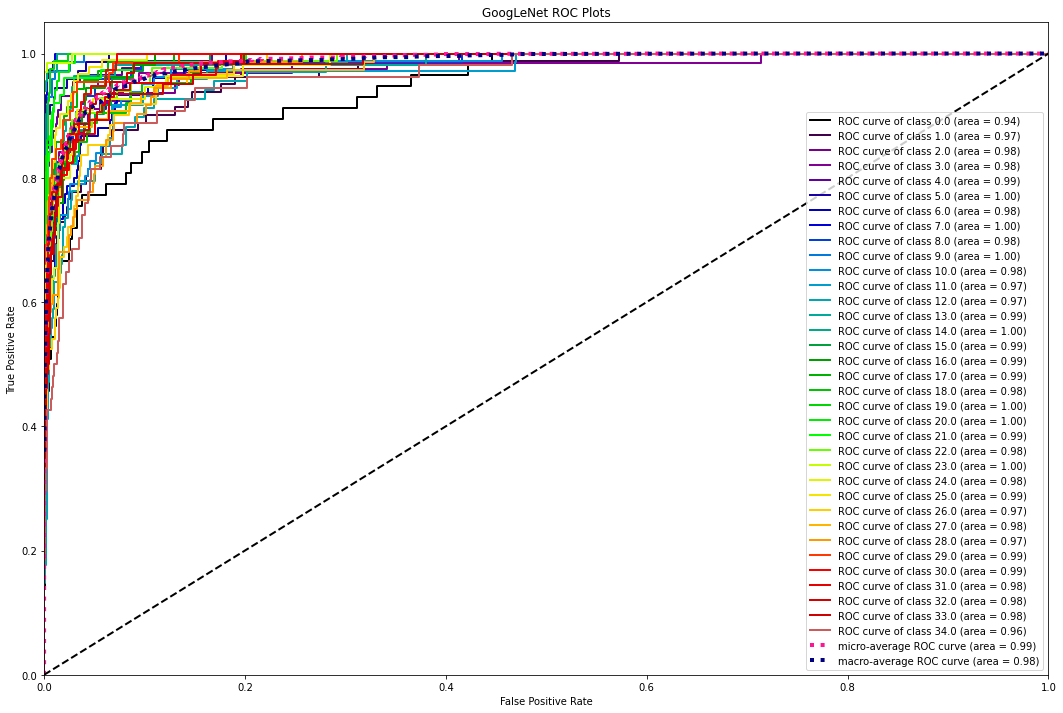

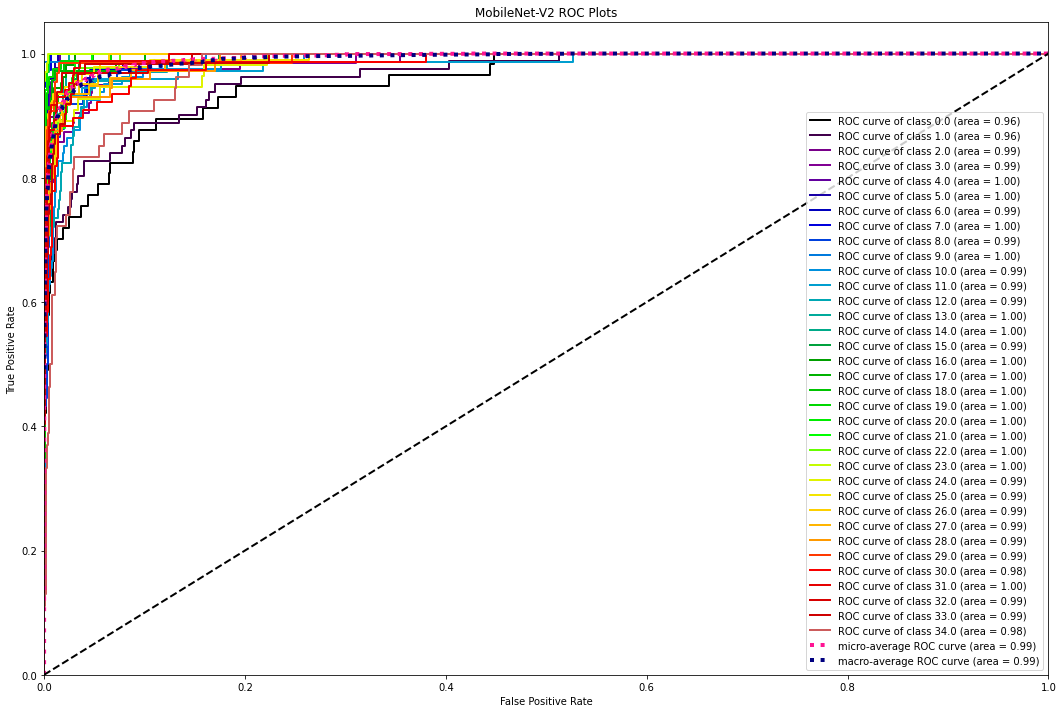

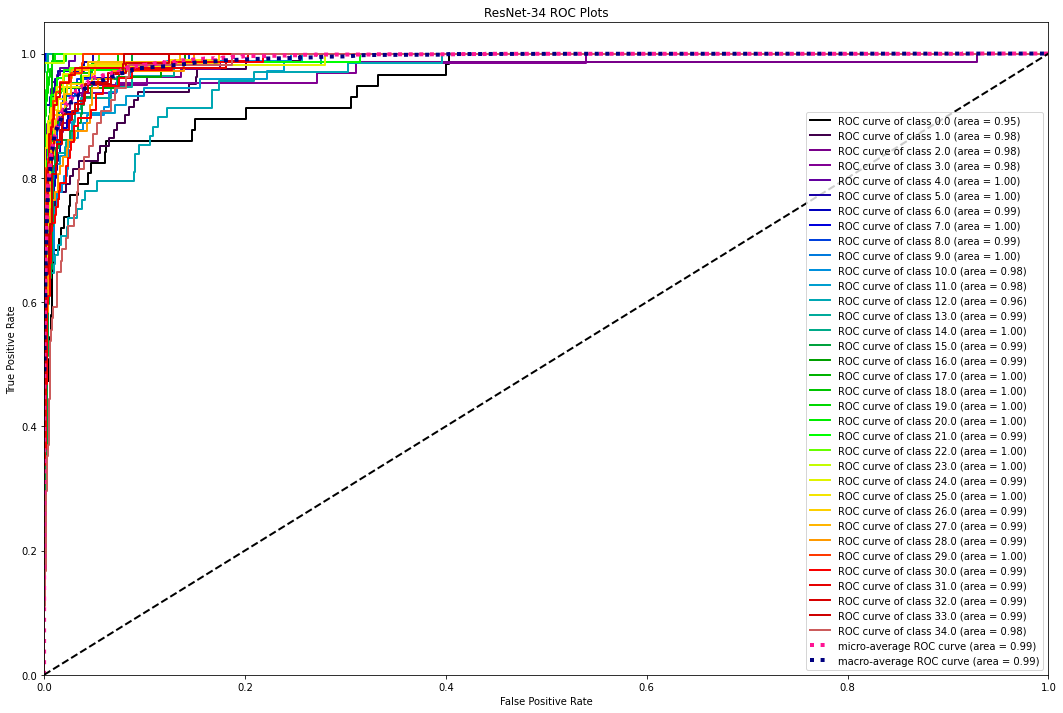

In [14]:
# Plot ROC curves
for idx, model in enumerate(best_models):
    vis.plot_roc(MODEL_NAMES[idx], model.y_probas, 
                 model.y_true, figsize=(18, 12))

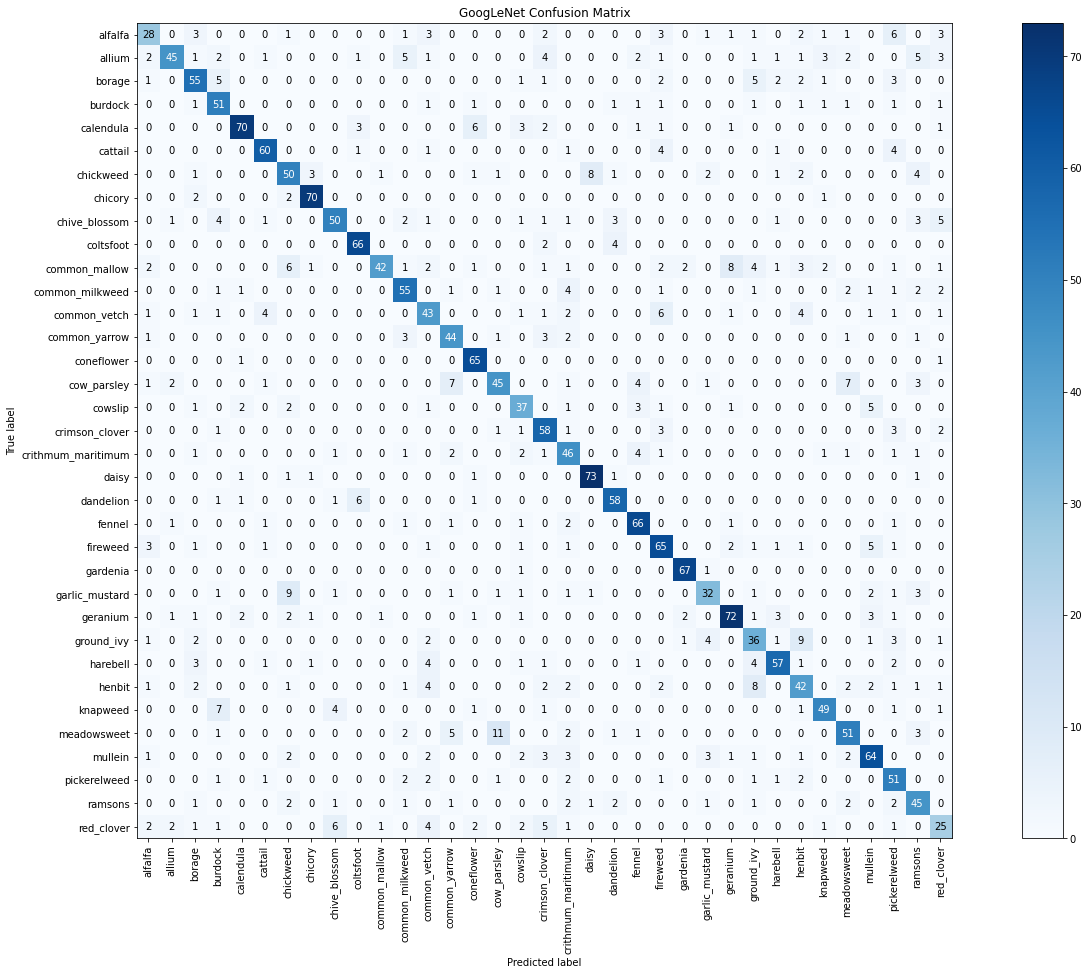

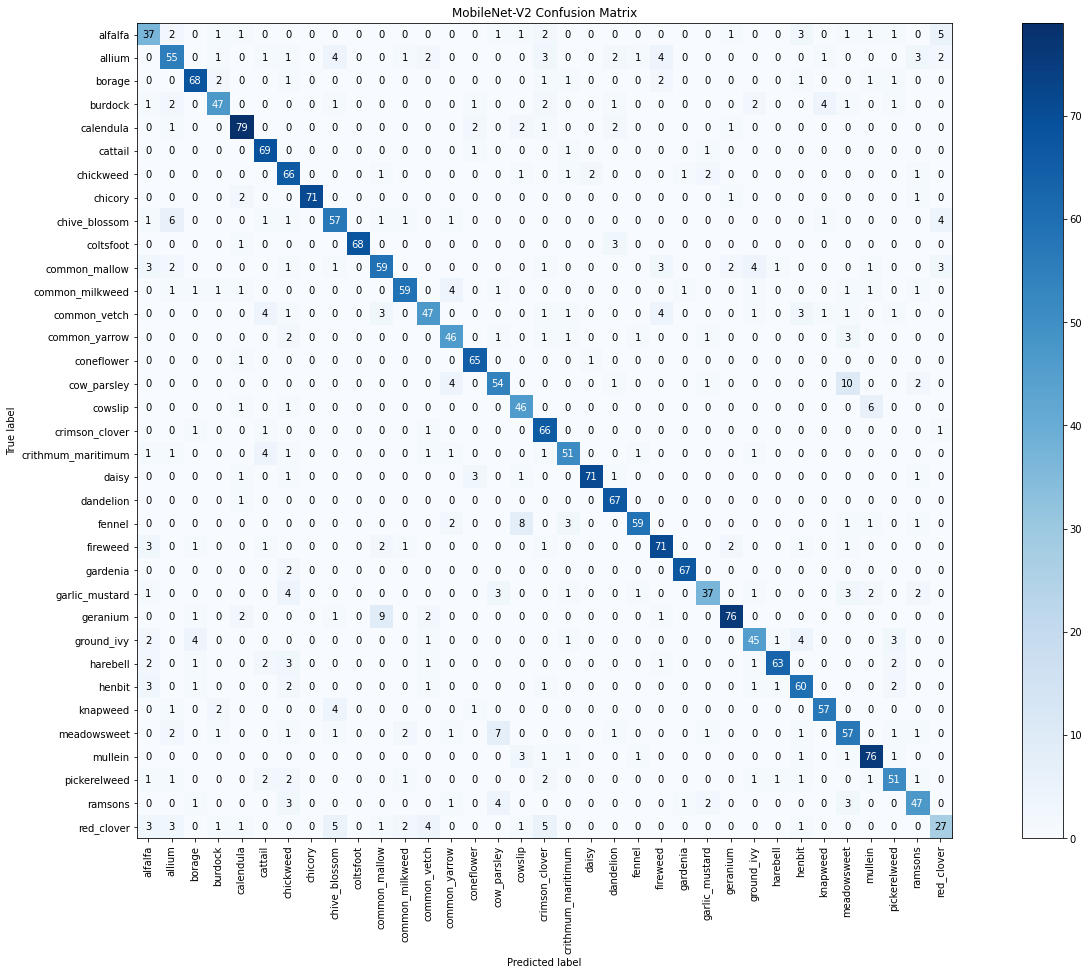

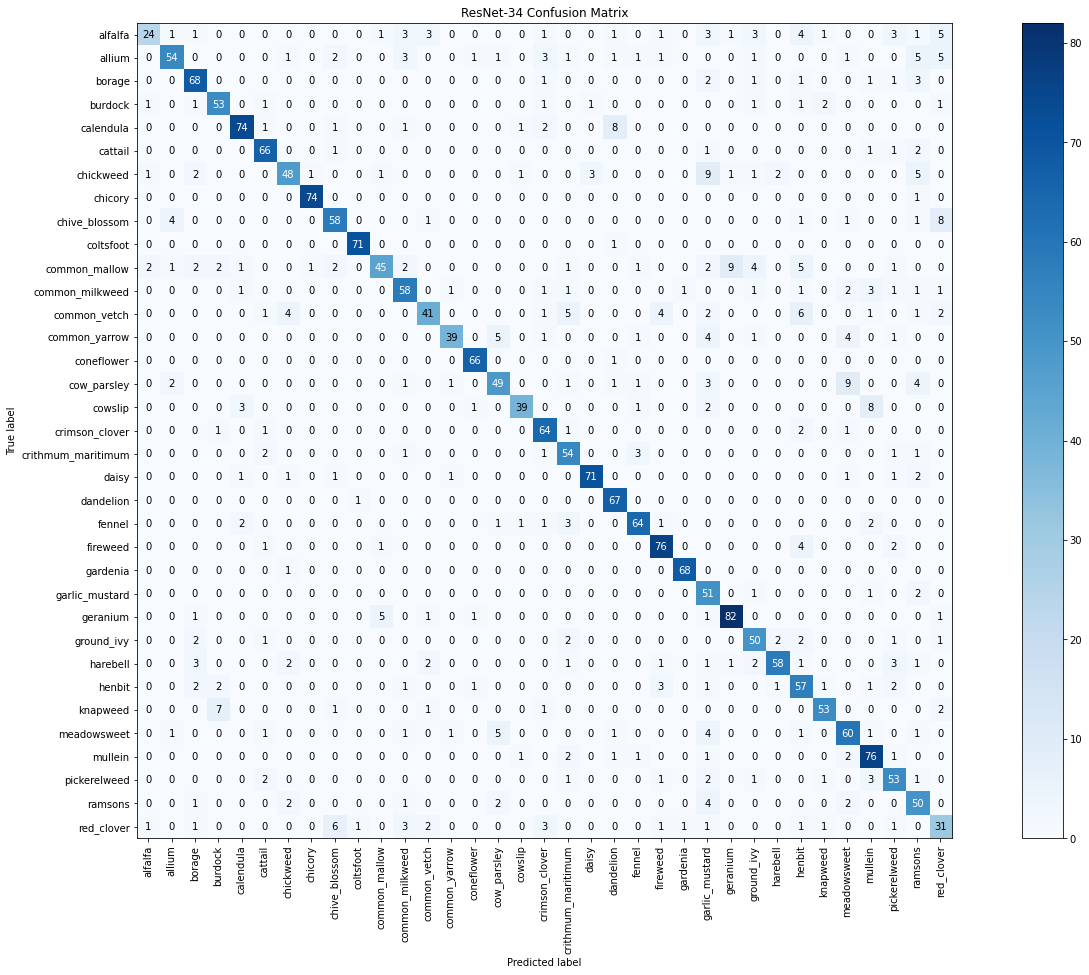

In [15]:
# Plot Confusion Matrices
for idx, model in enumerate(best_models):
    y_pred_cm, y_true_cm = tune.utils.indices_to_labels(model.y_pred, model.y_true, 
                                                        tune.labels)
    vis.plot_cm(MODEL_NAMES[idx], y_pred_cm, y_true_cm)

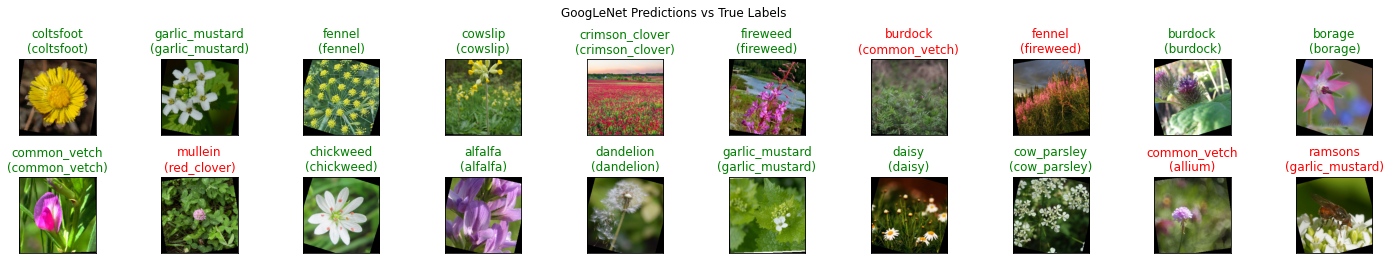

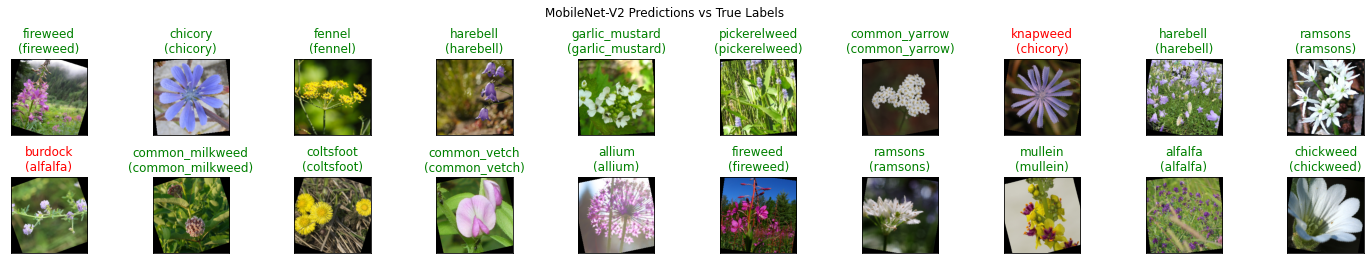

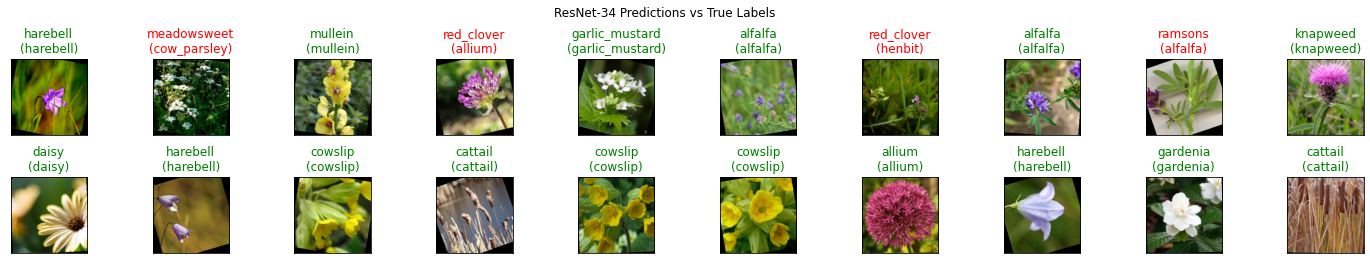

In [16]:
vis.plot_model_predictions(best_models, MODEL_NAMES, BATCH_SIZES, MAIN_FILEPATH, 
                           SPLIT_SIZE, SEED)